# Calculate Potential Vorticity (PV)
# The following example makes use of a typical output file from the Weather Research and Forecasting (WRF) model. 
# Input file format: NetCDF 

$$q_{p} = -g\left(f\mathbf{k} + \nabla_{p} \times \mathbf{v} \right)\cdot \nabla_{p}\theta$$

$$ \mathbf{v} \equiv (u, v) $$
$$ \nabla_{p} \equiv \left( \partial_{x}, \partial_{y}, \partial_{p} \right) $$

In [1]:
from __future__ import print_function
from netCDF4 import Dataset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ncfile = Dataset("/Users/konmenelaou/Desktop/PYTHON/WORKcalculations/wrfout_d03_1111-01-01_00:00:00")
#unstagger U and V
u0 = ncfile.variables['U'][:,:,:,:]
U = ( u0[ :, :, :, :-1 ] + u0[ :, :, :, 1: ] ) / 2
v0 = ncfile.variables['V'][:,:,:,:]
V = ( v0[ :, :, :-1, : ] + v0[ :, :, 1:, : ] ) / 2

#full pressure
p0 = ncfile.variables['P'][:,:,:,:]
pb0 = ncfile.variables['PB'][:,:,:,:]
P = p0 + pb0

#Potential temperature
t0 = ncfile.variables['T'][:,:,:,:]
TH = t0 + 300

#Coriolis Parameter
F = ncfile.variables['F'][:,:,:]

#The grid spacing here is dx=dy=666.66 meters (already known)
dx = 666.66

In [3]:
#consider only an instantaneous field for this example: t=0
U3d = U[0,:,:,:]
V3d = V[0,:,:,:]
P3d = P[0,:,:,:]
TH3d = TH[0,:,:,:]
F2d = F[0,:,:]

In [4]:
#################
def wrf_pv( U, V, F, THETA, PRES, dx ):
    dy = dx
    grav = 9.8

    dVp,dVy,dVx = np.gradient( V )
    dUp,dUy,dUx = np.gradient( U )
    dTp,dTy,dTx = np.gradient( THETA )
    dp,dPy,dPx = np.gradient( PRES )
    return ( -grav * ( -dVp/dp * dTx/dx + dUp/dp * dTy/dy + ( dVx/dx - dUy/dy + F ) * dTp/dp ) ) * pow(10, 6)
# * pow(10, 6) = returns PV in common PVU units 
#################

In [5]:
PV = wrf_pv(U3d, V3d, F2d, TH3d, P3d,  dx )

In [6]:
#create a suitable meshgrid in km which is centered in the middle of the domain 
zDIM, yDIM, xDIM = PV.shape
x = np.linspace(1, xDIM, xDIM)
y = np.linspace(1, yDIM, yDIM)
x = (x - xDIM/2)*dx/1000
y = (y - yDIM/2)*dx/1000
X, Y = np.meshgrid(x, y)

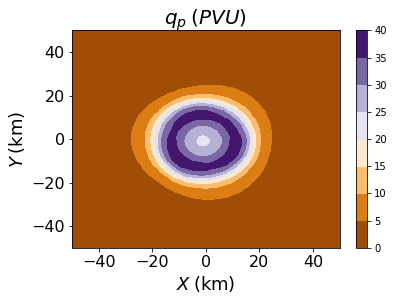

In [7]:
#plot PV at a selected vertical level k=7 (arbitrary choice)
PV2D = PV[7,:,:]
fig = plt.figure()
cmap = plt.get_cmap('PuOr')

levelsH = np.arange(0, 40, 2.5)
cset = plt.contourf(X, Y, PV2D, cmap=cmap, alpha=1.0)
plt.colorbar()

plt.xlim((-50, 50))
plt.ylim((-50, 50))

plt.xlabel('$X \: (\mathrm{km})$',fontsize=18)
plt.ylabel('$Y \: (\mathrm{km})$',fontsize=18)

plt.title('$q_{p} \: (PVU)$',fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()
